In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from py_scripts.db_fcns import save_df_to_db, get_df_from_db
from py_scripts.trainlocations import StationsAndDates, TrainLocations

In [2]:
reset_raw_data = False
do_processing = False
reset_checkpoints = False

choose_route = False

alkuasema = "JY"
loppuasema = "TPE"

alkupvm = "2018-01-01"
loppupvm = "2023-06-30"

asemat_ja_paivat = StationsAndDates(alkuasema, loppuasema, alkupvm, loppupvm)

In [3]:
tl = TrainLocations(asemat_ja_paivat)

In [4]:
tl.load_raw_data_from_db()

if tl.train_df is not None and tl.timetables is not None and tl.location_df_raw is not None:
    print(f"Trains loaded from DB: {len(tl.train_df)}")
    print(f"Trains with timetables: {len(tl.timetables.groupby(['departureDate', 'trainNumber']).count())}")
    print(f"Trains with locations: {len(tl.location_df_raw.groupby(['departureDate', 'trainNumber']).count())}")

Trains loaded from DB: 19747
Trains with timetables: 19158
Trains with locations: 18684


In [5]:
tl.find_data(do_limiting=reset_raw_data, force_reset=reset_raw_data)   

if_exists_action = "replace" if reset_raw_data else "fail"
tl.save_raw_data_to_db(if_exists_action=if_exists_action)

Table timetables already exists
Table locations_raw already exists
Table trains already exists


## Katsotaan eri reittivaihtoehtoja

In [6]:
routes = tl.get_routes()
routes[routes > 100]

(JY, MUU, JÄS, OV, TPE)                            8100
(JY, JÄS, OV, TPE)                                 6645
(JY, PVI, KEU, HPK, KLO, VLP, JJ, OVK, OV, TPE)    1268
(JY, TPE)                                           769
(JY, JÄS, TV, OV, TPE)                              712
(JY, JÄS, TPE)                                      654
(JY, SAA, TPE)                                      350
(JY, MUU, SAA, JÄS, OV, TPE)                        343
(JY, JÄS, LPR, OV, TPE)                             260
(JY, MUU, JÄS, TPE)                                 211
(JY, SAA, TV, TPE)                                  117
Name: stations, dtype: int64

In [7]:
pd.pivot_table(tl.train_df[tl.train_df["stations"].isin(routes[routes > 100].index)], values="timetableType", index=["stations"], columns=["trainType"], aggfunc=pd.Series.count)

trainType,HDM,IC,LIV,MV,P,S,T,TYO,VET
stations,,,,,,,,,
"(JY, JÄS, LPR, OV, TPE)",NaN,NaN,NaN,NaN,NaN,260.0,NaN,NaN,NaN
"(JY, JÄS, OV, TPE)",NaN,5334.0,NaN,NaN,NaN,1307.0,4.0,NaN,NaN
"(JY, JÄS, TPE)",NaN,NaN,NaN,7.0,1.0,596.0,43.0,NaN,7.0
"(JY, JÄS, TV, OV, TPE)",NaN,602.0,NaN,NaN,NaN,110.0,NaN,NaN,NaN
"(JY, MUU, JÄS, OV, TPE)",NaN,4263.0,NaN,NaN,NaN,3833.0,4.0,NaN,NaN
"(JY, MUU, JÄS, TPE)",NaN,NaN,NaN,1.0,NaN,206.0,3.0,NaN,1.0
"(JY, MUU, SAA, JÄS, OV, TPE)",NaN,341.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN
"(JY, PVI, KEU, HPK, KLO, VLP, JJ, OVK, OV, TPE)",1268.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(JY, SAA, TPE)",NaN,NaN,1.0,4.0,NaN,NaN,343.0,NaN,2.0


## Valitaan reitti

In [8]:
r_hki_ol = ('HKI', 'PSL', 'TKL', 'TPE', 'SK', 'KOK', 'YV', 'OL')
r_jy_tpe = ('JY', 'JÄS', 'OV', 'TPE')
r_tpe_jy = ('TPE', 'OV', 'JÄS', 'JY')

if r_hki_ol in routes.index:
    route = r_hki_ol
elif r_jy_tpe in routes.index:
    route = r_jy_tpe
elif r_tpe_jy in routes.index:
    route = r_tpe_jy

if choose_route:
    indeksi = input("Valitse indeksi: ")
    # indeksi = "0"

    try:
        indeksi = int(indeksi)
        route = routes.index[indeksi]
    except ValueError:
        route = tuple([s.strip() for s in indeksi.split(",")])

print(route)

('JY', 'JÄS', 'OV', 'TPE')


## Ladataan prosessoitu data tietokannasta, jos mahdollista

In [9]:
tl.load_checkpoint_data_from_db(route, verbose=False)

## Prosessoidaan data, jos tarpeen

In [10]:
if not tl.checkpoint_data_exists():
    do_processing = True

In [11]:
if do_processing:
    interval_dfs = tl.process_train_locations(route)

In [12]:
if do_processing:
    tl.calculate_best_distance_estimate(method="median", num_of_decimals=-2)

#### Parhaat välimatka-estimaatit

In [13]:
# for dc in tl.interval_dfs:
#     print(f"{dc.get_interval_name()}: \t {dc.distance}")

pd.DataFrame([[idf.get_interval_name(), idf.distance] for idf in tl.interval_dfs], columns=["interval", "distance"])

,interval,distance
0,JY-JÄS,56900.0
1,JÄS-OV,55900.0
2,OV-TPE,41000.0


#### Poistetaan data, jonka antamat etäisyydet poikkeavat liikaa mediaanista

In [14]:
if do_processing:
    _ = tl.filter_data_based_on_distance(percentage=2, min_error=500)

In [15]:
# for idf in tl.interval_dfs:
#     print(f"{idf.get_interval_name()}: \t {len(idf.trains[idf.trains['in_analysis'] == True])}")

pd.DataFrame([[idf.get_interval_name(), len(idf.trains[idf.trains["in_analysis"] == True])] for idf in tl.interval_dfs], columns=["interval", "num_of_trains"])

,interval,num_of_trains
0,JY-JÄS,4265
1,JÄS-OV,5262
2,OV-TPE,3934


## Jaetaan kukin välimatka tasaisin välein oleviin "checkpointteihin" ja analysoidaan dataa niiden avulla

In [16]:
if do_processing:
    tl.focus_on_checkpoints(checkpoint_interval=50)

In [17]:
# if do_processing:
#     tl.save_checkpoint_data_to_db()

In [18]:
if_exists_action2 = "replace" if reset_checkpoints else "fail"

if tl.clustering_data is None or reset_checkpoints:
    tl.calculate_accelerations()
    tl.get_checkpoint_data_for_full_route()

tl.save_checkpoint_data_to_db(if_exists_action=if_exists_action2)

Table checkpoint_locations already exists
Table trains_0 already exists
Table locations_0 already exists
Table checkpoint_locations_0 already exists
Table trains_1 already exists
Table locations_1 already exists
Table checkpoint_locations_1 already exists
Table trains_2 already exists
Table locations_2 already exists
Table checkpoint_locations_2 already exists


In [19]:
# tl.calculate_accelerations()

In [20]:
# tl.get_checkpoint_data_for_full_route()

## Klusteroidaan junavuorot kiihtyvyyksien mukaan

In [21]:
tl.setup_for_clustering()

In [22]:
tl.run_kmeans_clustering(5, rng=808)

#### Tarkastellaan klustereiden keskipisteitä ja kiihtyvyyksiä klustereissa

Clustering results for interval JY-TPE


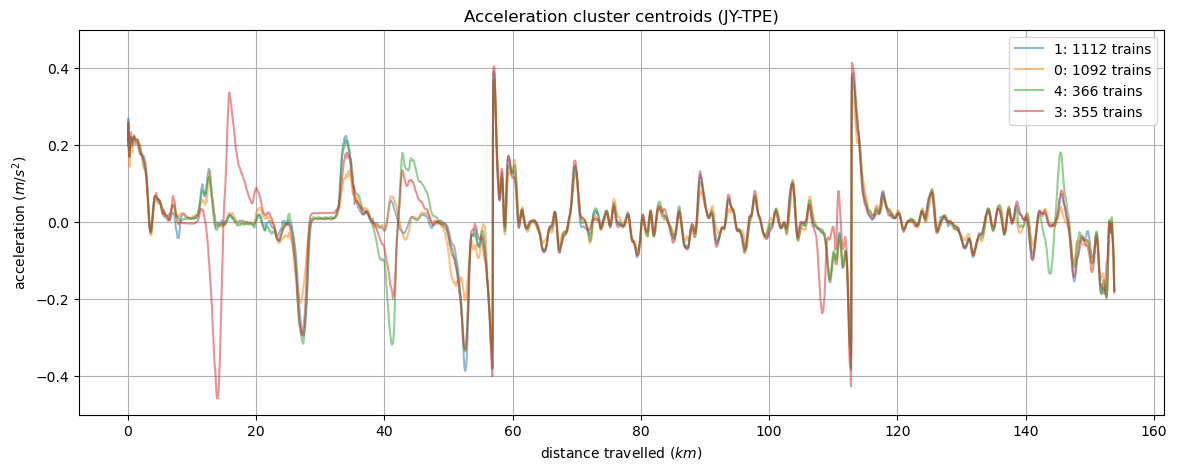

            count  min_abs_accel  max_abs_accel  median_abs_accel  \
cluster_id                                                          
1            1112    5659.518070   28309.531608      10652.117857   
0            1092    5366.176677   27915.884740      10713.005692   
4             366    7562.607906   19707.871374      11701.746988   
3             355    9057.800887   17947.180988      12192.512544   
2               1   13119.438433   13119.438433      13119.438433   

            mean_abs_accel  
cluster_id                  
1             11056.170771  
0             11084.654940  
4             11902.064612  
3             12336.538664  
2             13119.438433  

Clustering results for interval JY-JÄS


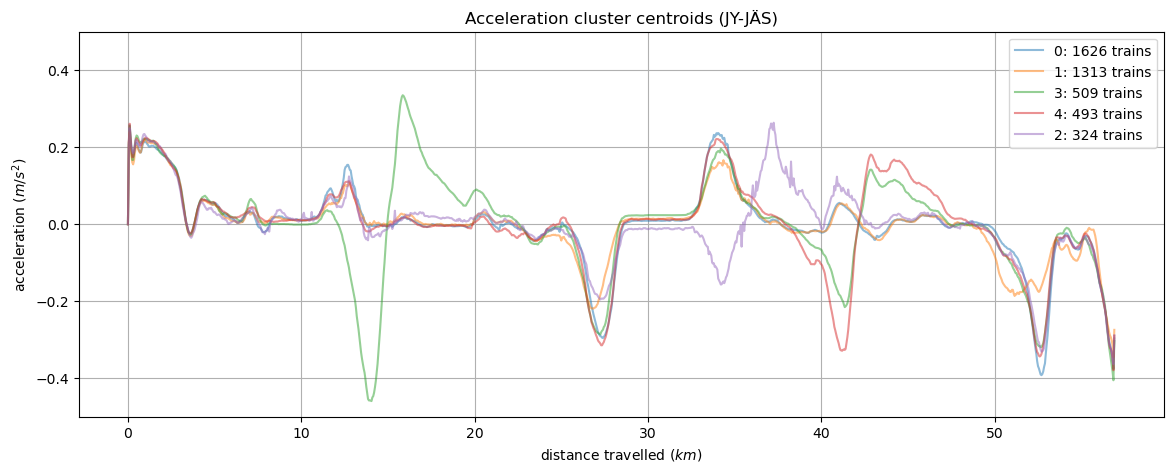

            count  min_abs_accel  max_abs_accel  median_abs_accel  \
cluster_id                                                          
1            1313    1401.515856    9858.122942       4225.335119   
0            1626    2367.224882    9619.663022       4262.179255   
2             324    2139.171744    9611.855387       4834.388294   
4             493    3418.107432    8369.547914       5175.516645   
3             509    3864.298199    9439.340986       6148.728700   

            mean_abs_accel  
cluster_id                  
1              4385.076222  
0              4453.082817  
2              4977.959440  
4              5313.946144  
3              6093.108646  

Clustering results for interval JÄS-OV


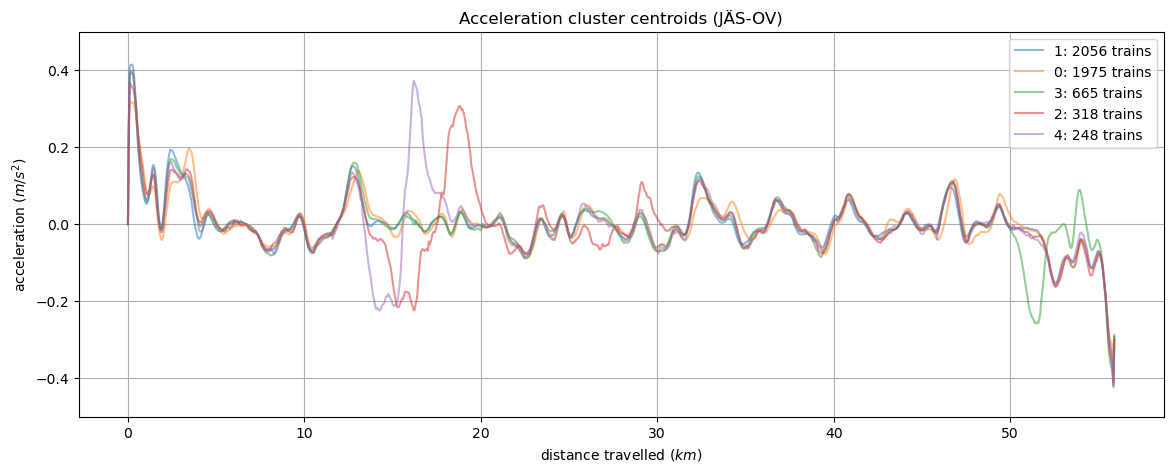

            count  min_abs_accel  max_abs_accel  median_abs_accel  \
cluster_id                                                          
3             665    1908.627491    8642.433579       3423.122653   
1            2056     867.005440   10409.396495       3506.027485   
0            1975     701.402610   10400.375013       3608.248590   
4             248    3000.313922    9437.702231       4338.002703   
2             318    3059.300232    9662.117562       4504.773086   

            mean_abs_accel  
cluster_id                  
3              3566.215432  
1              3635.172113  
0              3800.430365  
4              4427.863776  
2              4599.231104  

Clustering results for interval OV-TPE


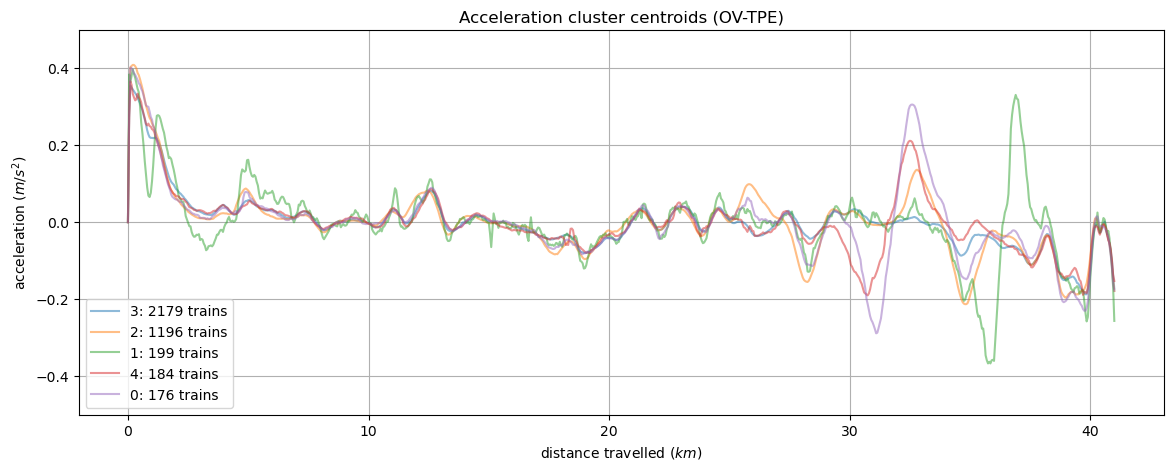

            count  min_abs_accel  max_abs_accel  median_abs_accel  \
cluster_id                                                          
3            2179    1118.371019    8464.757257       2544.567209   
2            1196    1686.498074    7313.100741       2853.722892   
4             184    1823.800149    6733.917407       2884.668052   
0             176    2151.578292    5754.318859       3326.824255   
1             199    2269.529301    9055.215904       4134.580499   

            mean_abs_accel  
cluster_id                  
3              2710.414173  
2              2974.756693  
4              3000.770198  
0              3365.285761  
1              4608.872664  



In [23]:
tl.show_clustering_results()

#### Korreloivatko kiihtyvyyksien suuruudet eri rataväleillä?

In [24]:
print(f"Trains with data everywhere: {len(tl.clustering_data.cluster_df)}")
tl.get_acceleration_correlations()

Trains with data everywhere: 2926


,JY-JÄS,JÄS-OV,OV-TPE
JY-JÄS,1.000000,0.304123,0.364163
JÄS-OV,0.304123,1.000000,0.694109
OV-TPE,0.364163,0.694109,1.000000


In [25]:
tl.get_acceleration_correlations(method="spearman")

,JY-JÄS,JÄS-OV,OV-TPE
JY-JÄS,1.000000,0.237076,0.328767
JÄS-OV,0.237076,1.000000,0.579393
OV-TPE,0.328767,0.579393,1.000000


#### Yritetään tarkastella, ovatko klusterit "samoja" eri rataväleillä

In [26]:
tl.compare_clusters()

JY-TPE vs. JY-JÄS
Accuracy: 0.8058783321941216

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1102
           1       0.70      0.85      0.77       897
           2       0.00      0.00      0.00       227
           3       0.98      0.98      0.98       355
           4       0.93      0.99      0.96       345

    accuracy                           0.81      2926
   macro avg       0.68      0.73      0.70      2926
weighted avg       0.75      0.81      0.78      2926


JY-TPE vs. JÄS-OV
Accuracy: 0.5676691729323309

              precision    recall  f1-score   support

           0       0.53      0.70      0.61      1112
           1       0.54      0.53      0.53      1126
           2       0.00      0.00      0.00       179
           3       0.80      0.76      0.78       374
           4       0.00      0.00      0.00       135

    accuracy                           0.57      2926
   macro avg       0.37      0.40 

c:\Users\kurui\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kurui\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kurui\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kurui\anaconda3\lib\site-packages\sklearn\metr

JY-TPE vs. OV-TPE
Accuracy: 0.570745044429255

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       126
           1       0.00      0.00      0.00       121
           2       0.50      0.20      0.28       917
           3       0.63      0.85      0.72      1621
           4       0.31      0.80      0.45       141

    accuracy                           0.57      2926
   macro avg       0.29      0.37      0.29      2926
weighted avg       0.52      0.57      0.51      2926


JY-JÄS vs. JÄS-OV
Accuracy: 0.49726589200273413

              precision    recall  f1-score   support

           0       0.47      0.53      0.50      1112
           1       0.44      0.52      0.48      1126
           2       0.00      0.00      0.00       179
           3       0.79      0.75      0.77       374
           4       0.00      0.00      0.00       135

    accuracy                           0.50      2926
   macro avg       0.34      0.36 

c:\Users\kurui\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kurui\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kurui\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kurui\anaconda3\lib\site-packages\sklearn\metr

JY-JÄS vs. OV-TPE
Accuracy: 0.5635680109364319

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       126
           1       0.00      0.00      0.00       121
           2       0.50      0.19      0.28       917
           3       0.62      0.85      0.71      1621
           4       0.29      0.70      0.41       141

    accuracy                           0.56      2926
   macro avg       0.28      0.35      0.28      2926
weighted avg       0.51      0.56      0.50      2926


JÄS-OV vs. OV-TPE


c:\Users\kurui\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kurui\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kurui\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5553656869446343

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       126
           1       0.00      0.00      0.00       121
           2       0.50      0.20      0.29       917
           3       0.56      0.89      0.69      1621
           4       0.00      0.00      0.00       141

    accuracy                           0.56      2926
   macro avg       0.21      0.22      0.20      2926
weighted avg       0.47      0.56      0.47      2926




c:\Users\kurui\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kurui\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kurui\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
